In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from src.paths import RAW_DATA_DIR, PREPROCESSED_DATA_DIR

import warnings
warnings.filterwarnings('ignore')

In [3]:
data_train = pd.read_csv(RAW_DATA_DIR / 'train.csv')
data_test = pd.read_csv(RAW_DATA_DIR / 'test.csv')

print(f'\n---TRAIN DATA---\nNumber of rows: {data_train.shape[0]}\nColumns: {data_train.columns.to_list()}')
print(f'\n---TEST DATA---\nNumber of rows: {data_test.shape[0]}\nColumns: {data_test.columns.to_list()}\n')

dfs = {
    'data_train': data_train,
    'data_test': data_test
}

for df_name in dfs.keys():
    print(df_name)
    print(f'\tNumber of nan: {dfs[df_name].isna().sum().sum()}')


---TRAIN DATA---
Number of rows: 10506
Columns: ['Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent']

---TEST DATA---
Number of rows: 116293
Columns: ['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy']

data_train
	Number of nan: 0
data_test
	Number of nan: 0


In [4]:
basic_features = ['Date', 'Trap', 'Species', 'Latitude', 'Longitude']  
data_train = data_train[basic_features + ['WnvPresent']]
data_test = data_test[basic_features + ['Id']]

data_train.Date = pd.to_datetime(data_train.Date)
data_test.Date = pd.to_datetime(data_test.Date)

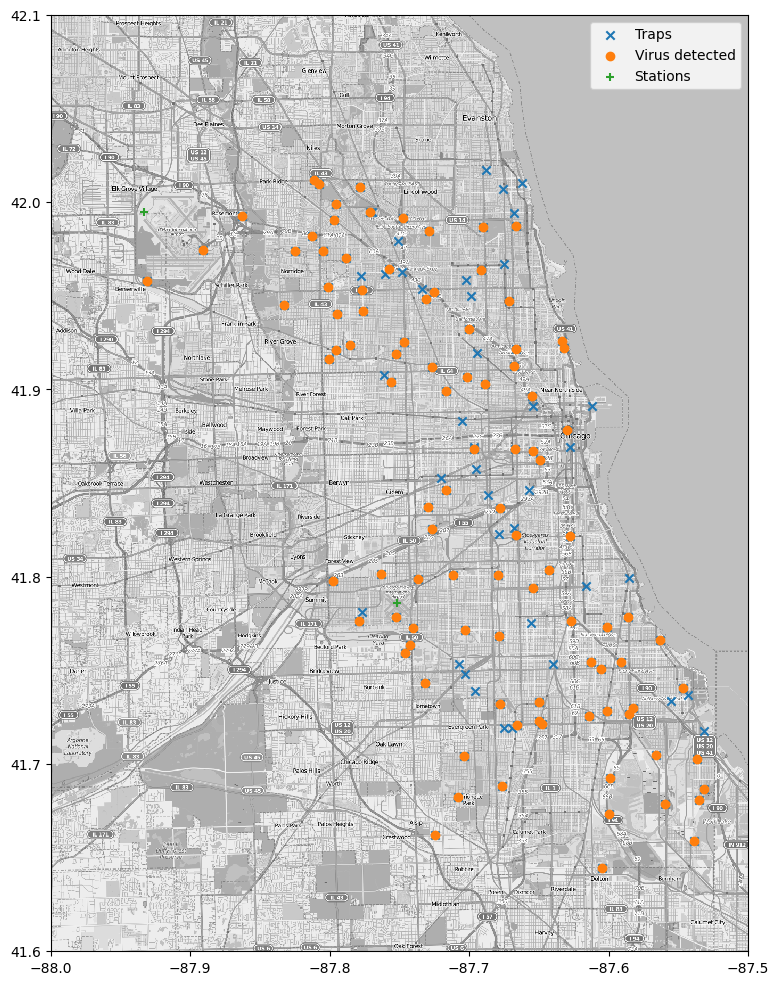

In [5]:
stations = np.array([[-87.933, 41.995],[-87.752, 41.786]])
image_arr = np.loadtxt(RAW_DATA_DIR / 'mapdata_copyright_openstreetmap_contributors.txt')
plt.figure(figsize=(9,13))
plt.imshow(image_arr, interpolation='nearest', cmap='gray', extent=(-88, -87.5, 41.6, 42.1), aspect=image_arr.shape[0]/image_arr.shape[1])
locations = data_train[['Longitude', 'Latitude']].drop_duplicates().values
locations_wnv = data_train[data_train.WnvPresent!=0][['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', label='Traps')
plt.scatter(locations_wnv[:,0], locations_wnv[:,1], marker='o', label='Virus detected')
plt.scatter(stations[:,0], stations[:,1], marker='+', label='Stations')
plt.legend()
plt.show()

In [6]:
species = data_train.Species.value_counts().to_frame()
species['wnv_present_cnt'] = data_train.groupby('Species').WnvPresent.sum()
species['wnv_present_pct'] = data_train.groupby('Species').WnvPresent.mean().round(4)*100
species

,count,wnv_present_cnt,wnv_present_pct
Species,,,
CULEX PIPIENS/RESTUANS,4752,262,5.51
CULEX RESTUANS,2740,49,1.79
CULEX PIPIENS,2699,240,8.89
CULEX TERRITANS,222,0,0.00
CULEX SALINARIUS,86,0,0.00
CULEX TARSALIS,6,0,0.00
CULEX ERRATICUS,1,0,0.00


In [7]:
possible_species = list(species[species.wnv_present_cnt!=0].index)
data_train = data_train[data_train.Species.isin(possible_species)]
data_test = data_test[data_test.Species.isin(possible_species)]

species2index = {
    possible_species[i]: i for i in range(len(possible_species))
}

data_train.Species = data_train.Species.map(species2index)
data_test.Species = data_test.Species.map(species2index)

In [8]:
def split_date(df):
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Week'] = df.Date.dt.isocalendar().week
    df['Dayofweek'] = df['Date'].dt.dayofweek
    df['Dayofyear'] = df['Date'].dt.dayofyear

split_date(data_train)
split_date(data_test)

In [9]:
display(data_train.groupby(['Month']).agg(
            positive_cases = ('WnvPresent','sum'),
            percent = ('WnvPresent',lambda x: (x.mean()*100).round(2))
            )
)
data_train.groupby(['Year']).agg(
    positive_cases = ('WnvPresent','sum'),
    percent = ('WnvPresent',lambda x: (x.mean()*100).round(2))
)

,positive_cases,percent
Month,,
5,0,0.00
6,1,0.07
7,46,1.82
8,377,10.36
9,125,5.82
10,2,0.76


,positive_cases,percent
Year,,
2007,236,6.45
2009,19,0.86
2011,57,2.94
2013,239,10.04


In [10]:
possible_months = [7,8,9]
data_train = data_train[data_train.Month.isin(possible_months)]
data_test = data_test[data_test.Month.isin(possible_months)]

In [11]:
possible_traps = data_train[data_train.WnvPresent!=0].Trap.unique()
data_train = data_train[data_train.Trap.isin(possible_traps)]
data_test = data_test[data_test.Trap.isin(possible_traps)]

In [12]:
data_train.WnvPresent.value_counts()

WnvPresent
0    6880
1     548
Name: count, dtype: int64